In [1]:
import numpy as np
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
from sklearn.neighbors import KNeighborsClassifier
from scipy.spatial import distance_matrix
from tsp_solver.greedy import solve_tsp

In [2]:
def efficient_min_distance_method(samples,p):
    tree = KDTree(samples)
    min_distance = np.inf
    closest_pair = (0, 0)

    for i in range(samples.shape[0]):
        distances, indices = tree.query(samples[i], k=2, p=p)  # k=2 返回最近的两个点（包括自身）
        if distances[1] < min_distance:  # distances[1] 是第二近的点（即除了自身外最近的点）
            min_distance = distances[1]
            closest_pair = (i, indices[1])

    return closest_pair

def K_Space(cluster_nums, samples, p=2):

    n = samples.shape[0]
    num_each_cluster = n // cluster_nums
    clusters = [[] for _ in range(cluster_nums+1)]
    cluster_centers = []
    samples_remaining = samples.copy()
    add_cluster_index = 0
    clusters_ = []
    time = 0

    while samples_remaining.shape[0] + len(cluster_centers)>1:
        #打印每次迭代的效果
        
        # print(f"第{time}次循环 samples_reminding:{samples_remaining.shape[0]} 临时类数量:{len(cluster_centers)} 产出类数量:{len(clusters_)}")
        
        matrix = np.vstack([samples_remaining,[i for i in cluster_centers]]) if len(cluster_centers)>0 else samples_remaining
        #首先计算合并的矩阵中距离最近的两个元素
        index1, index2 = efficient_min_distance_method(matrix,p=p)
        #求得两个元素是样本还是簇心
        label1 = 0 if index1 < samples_remaining.shape[0] else 1 # 0表示样本,1表示簇心
        label2 = 0 if index2 < samples_remaining.shape[0] else 1
        
        #样本点之间的合并
        if add_cluster_index < len(clusters) and label1+label2 == 0:
            clusters[add_cluster_index].extend([samples_remaining[index1], samples_remaining[index2]])
            cluster_centers.append(np.mean(clusters[add_cluster_index], axis=0))
            samples_remaining = np.delete(samples_remaining, [index1, index2], axis=0)
            add_cluster_index += 1
            # print(f"样本合并创建新类 ")
            
        #当簇的数量足够时,如果还是两个样本,则将两个样本作为一个整体加入距离簇心最近的类中
        elif add_cluster_index == len(clusters) and label1+label2 == 0:
            two_samples_mean = np.mean([samples_remaining[index1], samples_remaining[index2]],axis=0)
            # print(cluster_centers)
            # print(clusters)
            # print(clusters_)
            if add_cluster_index == 0 and len(clusters) == 0:
                clusters.append([])
                clusters.append([])
                clusters[add_cluster_index].extend([samples_remaining[index1], samples_remaining[index2]])
                cluster_centers.append(np.mean(clusters[add_cluster_index], axis=0))
                samples_remaining = np.delete(samples_remaining, [index1, index2], axis=0)
                add_cluster_index += 1
                # print(f"类数已充足,增加类数")
            else:
                cluster_centers_matrix = np.vstack([i for i in cluster_centers])
                tree = KDTree(cluster_centers_matrix)
                _, indices = tree.query(two_samples_mean, k=1, p=p)
                clusters[indices].extend([samples_remaining[index1], samples_remaining[index2]])
                cluster_centers[indices] = np.mean(clusters[indices], axis=0)
                samples_remaining = np.delete(samples_remaining, [index1,index2], axis=0)
                # print(f"两个样本归纳新类")
            
        #样本点添加到类中
        elif label1+label2 == 1:
            index_samples = index1 if label1 == 0 else index2
            index_cluster = index1-samples_remaining.shape[0] if label1 == 1 else index2-samples_remaining.shape[0]
            clusters[index_cluster].append(samples_remaining[index_samples])
            cluster_centers[index_cluster] = np.mean(clusters[index_cluster], axis=0)
            samples_remaining = np.delete(samples_remaining, index_samples, axis=0)
            # print(f"一个样本归纳新类")
           
        #类与类之间的合并
        else:
            index1 = index1 - samples_remaining.shape[0]
            index2 = index2 - samples_remaining.shape[0]
            if len(clusters[index1])+len(clusters[index2]) <= num_each_cluster:#如果两个类中样本合并的数量不足饱和
                clusters[index1] = clusters[index1]+clusters[index2]
                cluster_centers[index1] = np.mean(clusters[index1], axis=0)
                del clusters[index2]
                del cluster_centers[index2]
                add_cluster_index -= 1
            #使用lof算法剔除多余样本点
            else:
                points = np.vstack([clusters[index1]+clusters[index2]])
                del clusters[max(index1,index2)]
                del clusters[min(index1,index2)]
                del cluster_centers[max(index1,index2)]
                del cluster_centers[min(index1,index2)]
                lof_model = LocalOutlierFactor(n_neighbors=int(num_each_cluster/2),p=p)
                lof_model.fit_predict(points)
                score = abs(lof_model.negative_outlier_factor_)
                clusters_.append(list(points[np.argsort(score)[:num_each_cluster]]))
                samples_remaining = np.vstack([samples_remaining,points[np.argsort(score)[num_each_cluster:]]])
                add_cluster_index -= 2
            clusters.append([])
            # print(f"两个类合并")
            
        time += 1
        #剔除已经饱和的簇
        for i in range(add_cluster_index):
            if len(clusters[i]) >= num_each_cluster:
                clusters_.append(clusters[i])
                del clusters[i]
                del cluster_centers[i]
                add_cluster_index -= 1
                break
        #将最后剩余的样本点归纳为一个类
        if samples_remaining.shape[0] + len(cluster_centers) == 1:
            if len(clusters) == 0:
                break
            clusters_.append(clusters[0])
            

    return clusters_

#计算聚类效果
def calculate_indicator(samples,label):
    clusters_center = []
    for i in range(np.max(label+1)):
        center = np.mean(samples[np.where(label==i)],axis=0)
        clusters_center.append(center)
    clusters_center = np.array(clusters_center)
    m = 0
    for i in range(samples.shape[0]):
        distance = np.linalg.norm(samples[i,:]-clusters_center,axis=1)
        if np.argmin(distance) != label[i]:
            m += 1
            
    return m/samples.shape[0]
    
def list_transform_array(clusters):
    x_train = []
    y_train = []
    #将原本聚类结果完全转化为列表,导出label
    for i in range(len(clusters)):
        for j in range(len(clusters[i])):
            x_train.append(clusters[i][j])
            y_train.append(i)
    #将列表格式的数据转化为数组
    x_train = np.vstack(x_train)
    y_train = np.array(y_train)
    return x_train,y_train
    
def fine_turning(x_train,y_train):
    n,m = x_train.shape
    nums_class = np.max(y_train)+1
    #计算优化前的指标
    indicator = calculate_indicator(x_train,y_train)
    # print(f"优化前聚类效果指标:{indicator}")
    #选择机器学习模型进行预测,调整聚类结果
    knn = KNeighborsClassifier(n_neighbors=int(n/nums_class))
    knn.fit(x_train, y_train)
    predictions = knn.predict(x_train)
    # print(f"优化样本占比:{round((1-accuracy_score(y_train, predictions))*100,5)}%\n优化后聚类效果指标:{calculate_indicator(x_train,predictions)}")
    
    return x_train,predictions

def caculater_cluster_index(samples,cluster_label):
    cluster_center = []
    for i in range(max(cluster_label)+1):
        cluster = samples[np.where(cluster_label == i)]
        cluster_center.append(np.mean(cluster,axis=0))
    distance_matrix_ = distance_matrix(cluster_center,cluster_center)
    path = solve_tsp( distance_matrix_, endpoints = (0,0) )
    return path

def transform(b,c,index):
    conclusion = []
    for i in range(max(index)+1):
        number = index[i]
        conclusion.append(np.vstack(b[np.where(c==number)]))
    
    return conclusion

In [34]:
n = 500
m = 2
k = 5
np.random.seed(132)
samples = np.random.normal(0,10,(n,m))
samples[:100,:] -= 50
samples[100:200,:] -= 40
samples[200:300,:] -= 30
samples[300:400,:] -= 20
samples[400:,:] -= 10
a = K_Space(k,samples)
b,c = list_transform_array(a)
b,c = fine_turning(b,c)
index = caculater_cluster_index(b,c)
conclusion = transform(b,c,index)


/Users/dyk/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


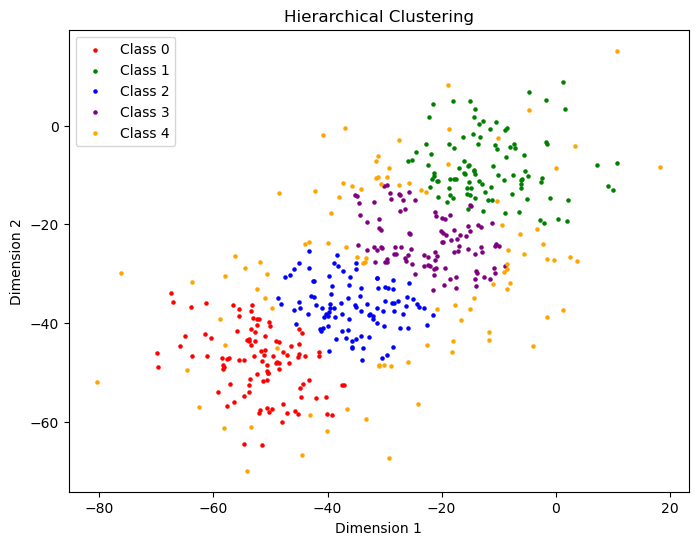

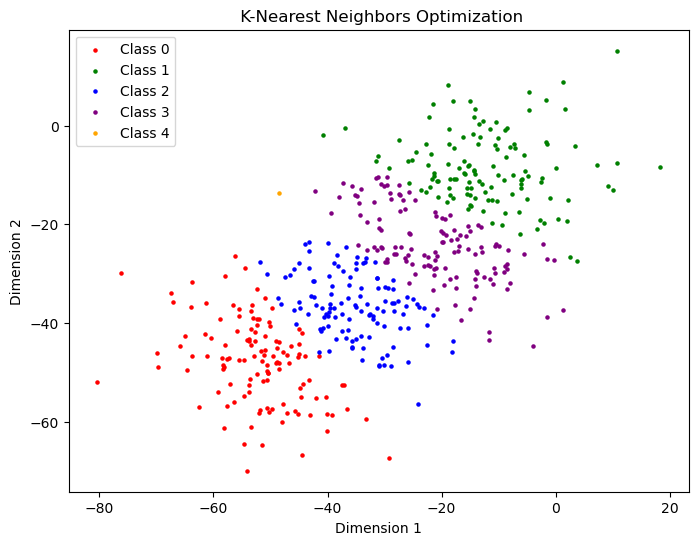

In [35]:
# 第一次聚类
# samples = np.random.normal(0,10,(2000,2))
# a = K_Space(k,samples)
# b,c = list_transform_array(a)
# b,c = fine_turning(b,c)
plt.figure(figsize=(8, 6))
for i in range(len(a)):
    a[i] = np.vstack([a[i]])
# 为每个类别的数据绘制散点图
colors = ['red', 'green', 'blue', 'purple', 'orange', "cyan",'magenta','yellow','pink',"black"]
for i, points in enumerate(a):
    plt.scatter(points[:, 0], points[:, 1], color=colors[i], label=f'Class {i}',s=5)
# 添加图例
plt.legend()
# 添加标题和坐标轴标签
plt.title("Hierarchical Clustering")
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
# 显示图像
plt.show()


#优化效果
plt.figure(figsize=(8, 6))
for i in range(5):
    indices = np.where(c == i)[0]
    plt.scatter(b[indices][:,0], b[indices][:,1], label=f'Class {i}',c=colors[i], s=5)

# 设置标题和标签
plt.title(' K-Nearest Neighbors Optimization')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
# 添加图例
plt.legend()
# 显示图像
plt.show()
